#   MODELO DE ÁRBOL DE DECISIÓN PARA PREDECIR goal_diff

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## Cargar y preparar los datos

In [3]:
DATA_PATH = r"../data/results_limpio.csv"
df = pd.read_csv(DATA_PATH)

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

df['home_score'] = pd.to_numeric(df['home_score'], errors='coerce')
df['away_score'] = pd.to_numeric(df['away_score'], errors='coerce')

df['goal_diff'] = df['home_score'] - df['away_score']
df['year'] = df['date'].dt.year

df['neutral'] = (
    df['neutral'].astype(str).str.lower().map({'true': 1, 'false': 0, '1': 1, '0': 0})
)
df['neutral'] = df['neutral'].fillna(0).astype(int)

df.head()   


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,goal_diff,is_neutral,year
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,0,0,0,1872
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,0,2,0,1873
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,0,1,0,1874
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,0,0,0,1875
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,0,3,0,1876


In [4]:
home_freq = df['home_team'].value_counts()
away_freq = df['away_team'].value_counts()

df['home_strength'] = df['home_team'].map(home_freq).fillna(0).astype(int)
df['away_strength'] = df['away_team'].map(away_freq).fillna(0).astype(int)

df[['home_team', 'home_strength', 'away_team', 'away_strength']].head(10)


,home_team,home_strength,away_team,away_strength
0,Scotland,412,England,539
1,England,545,Scotland,433
2,Scotland,412,England,539
3,England,545,Scotland,433
4,Scotland,412,England,539
5,Scotland,412,Wales,364
6,England,545,Scotland,433
7,Wales,356,Scotland,433
8,Scotland,412,England,539
9,Scotland,412,Wales,364


## Selección de características

In [5]:
features = ['neutral', 'year', 'home_strength', 'away_strength']
X = df[features].copy()
y = df['goal_diff'].copy()

# Escalado (los árboles no lo necesitan estrictamente, pero puede ayudar)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42
)


## Entrenamiento del Árbol de Decisión

In [6]:
features = ['neutral', 'year', 'home_strength', 'away_strength']
X = df[features].copy()
y = df['goal_diff'].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42
)

pd.DataFrame(X_scaled, columns=features).head()   

,neutral,year,home_strength,away_strength
0,-0.597624,-4.792523,0.746578,1.984741
1,-0.597624,-4.753032,1.645028,1.169812
2,-0.597624,-4.713541,0.746578,1.984741
3,-0.597624,-4.674050,1.645028,1.169812
4,-0.597624,-4.634559,0.746578,1.984741


# Evaluación

In [7]:
# Entrenar un árbol de decisión (si no está ya entrenado) y predecir sobre X_test
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

def metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

metrics_tree = metrics(y_test, y_pred_tree)
metrics_tree

{'MAE': 2.0651943160417736,
 'RMSE': np.float64(2.7894286564888238),
 'R2': -0.3245995557104331}

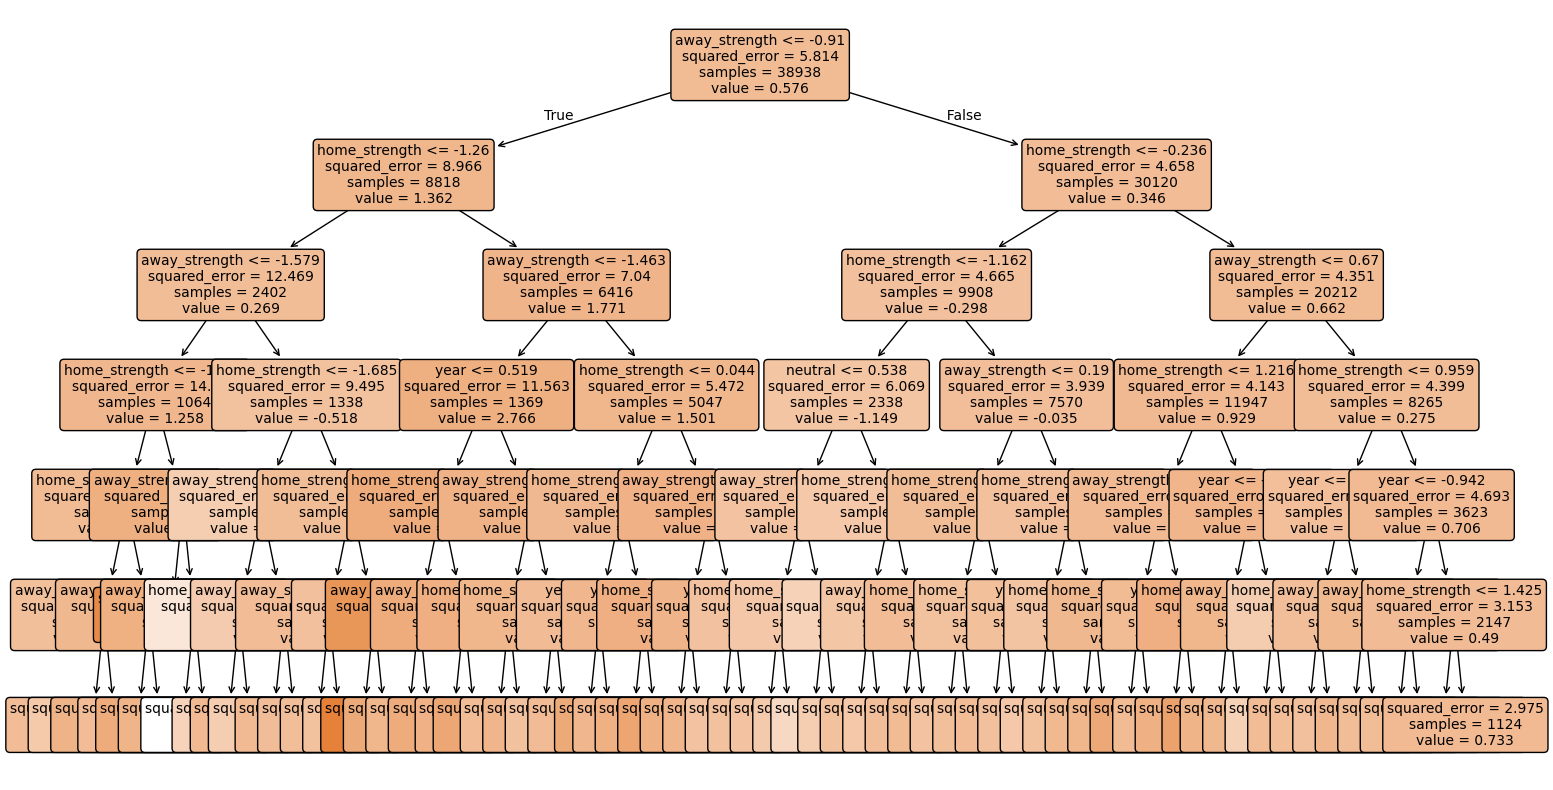

In [ ]:
plt.figure(figsize=(18, 10))
plot_tree(
    tree,
    feature_names=features,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()


El árbol de decisión deja ver que la variable que más influye en las predicciones es away_strength, ya que es la primera división del árbol y marca cómo se separan los datos desde el comienzo. Luego entran otras variables como home_strength, neutral y year, pero lo hacen en niveles más profundos, lo que indica que su efecto es más puntual y depende del contexto.

También se nota que el modelo genera muchas ramas pequeñas, lo cual significa que intenta adaptarse muy específicamente a los datos. Esto puede ayudar a capturar patrones detallados, pero también aumenta el riesgo de que el modelo se vuelva demasiado específico y pierda capacidad de generalización. En resumen, el árbol muestra bien cómo se comporta el modelo: muy segmentado, muy detallado y apoyándose sobre todo en la fuerza del equipo visitante.

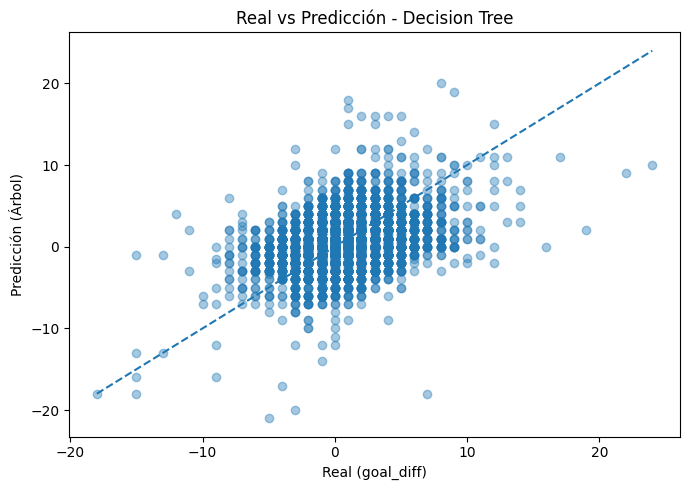

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_tree, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--")
plt.xlabel("Real (goal_diff)")
plt.ylabel("Predicción (Árbol)")
plt.title("Real vs Predicción - Decision Tree")
plt.tight_layout()
plt.show()


El gráfico de valores reales vs predicciones del árbol de decisión muestra que el modelo logra seguir la tendencia general entre la diferencia de goles real y la estimada, pero con bastante dispersión alrededor de la línea ideal. Se nota que el modelo repite muchos valores de predicción, algo típico en los árboles porque generan resultados por rangos y no de forma continua. Aunque captura el comportamiento global, la variabilidad es alta, especialmente en los valores extremos, lo que indica que el árbol no es tan preciso cuando la diferencia de goles se vuelve más grande o más inusual.

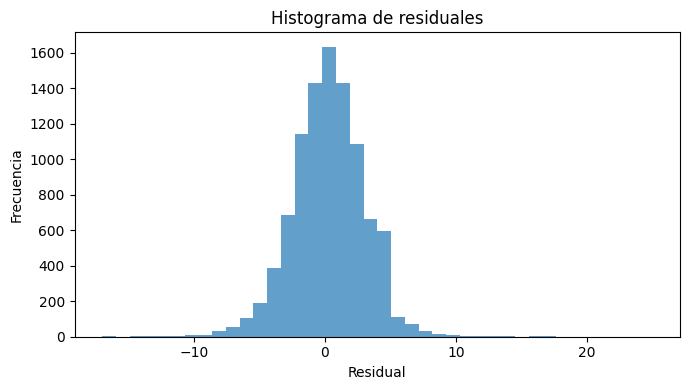

In [9]:
residuals = y_test - y_pred_tree

plt.figure(figsize=(7,4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.title("Histograma de residuales")
plt.xlabel("Residual")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


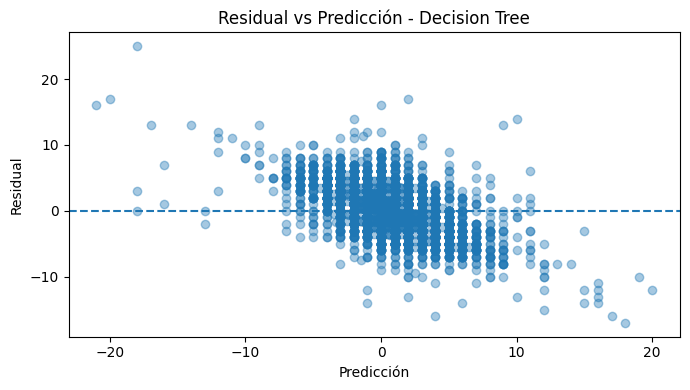

In [ ]:
plt.figure(figsize=(7,4))
plt.scatter(y_pred_tree, residuals, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual")
plt.title("Residual vs Predicción - Decision Tree")
plt.tight_layout()
plt.show()
